In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install MTCNN
!pip install keras
!pip install keras_vggface
!pip install keras_applications

     |████████████████████████████████| 2.3 MB 4.9 MB/s 
     |████████████████████████████████| 50 kB 2.7 MB/s 


In [ ]:
from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Dense, Dropout, Input

In [ ]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications --no-deps
filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-1ai692bq
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-1ai692bq


20951

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from mtcnn.mtcnn import MTCNN
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
from scipy.spatial.distance import cosine
import urllib.request
import requests
import threading
import random
import csv
import os
import datetime

In [ ]:
def face_det_ext(img):
    face_det = MTCNN() 
    faces = face_det.detect_faces(img)
    co = list(faces[0]['box'])
    x1 , y1 , x2 , y2 = co[0] , co[1] , co[0]+co[2] , co[1]+co[3]
    cp = img[y1:y2,x1:x2]
    cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),3)
    return [cp,img]
def pre_proc(img1):
    img1 = cv2.resize(img1 , (224,224))
    img1 = np.expand_dims(img1,axis=0)
    return img1
def get_model_scores(faces):
    samples = np.array(faces, 'float32')
    samples = preprocess_input(samples, version=2)
    model = VGGFace(model='resnet50',
      include_top=False,
      input_shape=(224, 224, 3),
      pooling='avg')
    return model.predict(samples)

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


In [48]:
from PIL import Image
import glob
import cv2
import glob

def register():
    ch="y"

    imdir = '/content/drive/MyDrive/Jcomp pics/'
    ext = ['jpeg']    # Add image formats here
    files = []
    [files.extend(glob.glob(imdir + '*.' + e)) for e in ext]

    images = [cv2.imread(file) for file in files]
    for img in images:
        #print(img)
        plt.imshow(img)
        img , fimg = face_det_ext(img)
        img = pre_proc(img)
        score = get_model_scores(img)
        name = input("Give name")
        scores.append([score,name])
        #ch = input("wanna add more faces? (y/n)")
        cv2.putText(fimg,"Registered", (10,50), cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
        plt.imshow(fimg)

def csv_write(data):
  path = "/content/drive/My Drive/attendance.csv"
  with open(path , "w" , newline="") as csvf:
    writ = csv.writer(csvf)
    writ.writerow(data)

def thingspeak_post(valm):
    #threading.Timer(15,thingspeak_post).start()
    val= "x"+valm
    URl='https://api.thingspeak.com/update?api_key='
    KEY='ADR6SK1Q6AI4KFZZ'
    HEADER='&field1={}'.format(val)
    NEW_URL = URl+KEY+HEADER
    print(NEW_URL)
    data=urllib.request.urlopen(NEW_URL)
    print(data)

def scan():
    filename = take_photo()
    print('Saved to {}'.format(filename))
    img = plt.imread("/content/photo.jpg")
    img ,img1 = face_det_ext(img)
    img = pre_proc(img)
    sc = get_model_scores(img)
    flag = 0
    for score in scores:
        if(cosine(score[0],sc)<0.4):
            print("hi ",score[1])
            cv2.putText(img1,"Hi "+score[1],(10,50), cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
            flag=1
            k = "y"
            plt.imshow(img1)
            break
    if flag==0:
        print("Wait a minute who are you")
        cv2.putText(img1,"Face not registered", (10,50), cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
        flag=1
        k = "y"
        plt.imshow(img1)
        k = "n"
    thingspeak_post(k)


IndexError: ignored

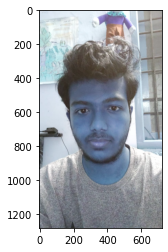

In [49]:
scores = []
register()

<IPython.core.display.Javascript object>

Saved to photo.jpg
Wait a minute who are you
https://api.thingspeak.com/update?api_key=ADR6SK1Q6AI4KFZZ&field1=xn


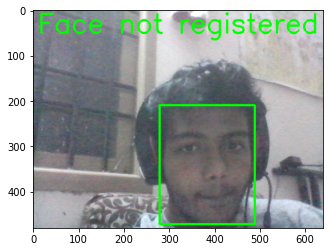

In [ ]:
scan()